In [2]:
import numpy as np
import os
import librosa
import pydub
from pydub import AudioSegment
import scipy
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [4]:
def trim_audio(audio):
    start_trim = detect_leading_silence(audio)
    end_trim = detect_leading_silence(audio.reverse())

    duration = len(audio)    
    trimmed_sound = audio[start_trim:duration-end_trim]
    return trimmed_sound

In [5]:
def createSample(environment_path:str, overlay_path:str):
        '''
        Creates a mono, frame rate matched sample with random position and volume overlay.
        Creates a label array 'y' of 1 for overlay and 0 for environment only
        '''
        environment = AudioSegment.from_file(environment_path, format="wav",
                                   frame_rate=44100, sample_width=2)
        environment = environment.set_channels(1)
        env_frame_rate = environment.frame_rate
        #env_frame_rate = int(44e3)#Hz
        #environment = environment.set_frame_rate(env_frame_rate)
        ENV_LENGTH = int(5 * 1000) # 5 seconds
        env_clip_start = random.randint(0, len(environment) - ENV_LENGTH)
        env_clip = environment[env_clip_start:env_clip_start+ENV_LENGTH]

        overlay = AudioSegment.from_file(overlay_path, format="wav", sample_width=2)
        overlay = trim_audio(overlay)
        overlay = overlay.set_channels(1)
        overlay = overlay.set_frame_rate(env_frame_rate) # Give everything a consistent frame rate
        rand_pos = random.randint(0, ENV_LENGTH - len(overlay))
        rand_volume = random.randint(-25, 10) # dB
        out_clip = env_clip.overlay(overlay + rand_volume, position=rand_pos)
        #out_clip = out_clip.low_pass_filter(16000).high_pass_filter(5000)
        
        y = np.empty(ENV_LENGTH, dtype='int0')
        for x in range(ENV_LENGTH):
            if x < rand_pos or x > rand_pos+len(overlay):
                y[x] = int(0)
            else:
                y[x] = int(1)

        return out_clip, y


In [6]:
def audio2np(audio:AudioSegment):
        '''
        Converts pydub audio data to numpy array
        '''
        samples = audio.get_array_of_samples()
        fp_arr = np.array(samples).T.astype(np.float32)
        return fp_arr

In [7]:
def downSample(data,rolling_window,step):
    import statistics as st
    smoothed_output = np.array([],dtype='int0')
    #data = np.pad(data,(rolling_window//2,rolling_window//2))
    k = int(0)
    for i in range(0,(len(data)-rolling_window)//step):
        k = st.mode(data[step*i:step*i+rolling_window])
        #print(k,i)
        k = int(k)
        smoothed_output = np.append(smoothed_output,k)
    #smoothed_output = np.append(smoothed_output,np.zeros([int(rolling_window/2),1],dtype=int))
    return smoothed_output

In [8]:
def createDatasetFancy(folder_name, num_samples):
    '''
    Returns a numpy array of audio samples.
    '''

    # enrionment_path
    environment_dir = 'environment_sounds'
    all_environment_files = []
    for x in os.listdir(environment_dir):
        if x.endswith(".wav"):
            all_environment_files.append(x)

    # gunshot path
    overlay_dir = 'kaggle_sounds'
    all_overlay_files = []
    for x in sorted(os.listdir(overlay_dir)):
        if x != '.DS_Store':
            for y in sorted(os.listdir(f'{overlay_dir}/{x}')):
                if y.endswith(".wav"):
                    all_overlay_files.append(f'{x}/{y}')


    print('Generating Dataset...')
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    for i in tqdm(range(0,num_samples)):
        random_environment_file = random.choice(all_environment_files)
        environment_path = f'{environment_dir}/{random_environment_file}'

        random_overlay_file = random.choice(all_overlay_files)
        overlay_path = f'{overlay_dir}/{random_overlay_file}'

        audio, y = createSample(environment_path, overlay_path)
        y = downSample(y,90,90)
        #print(y.shape)
        audio.export(f'{folder_name}/sample_{i+1}.wav', format="wav")
        np_array = audio2np(audio)
        np.savetxt(f'{folder_name}/sample_{i+1}.csv', np_array, delimiter=",")
        np.savetxt(f'{folder_name}/label_{i+1}.csv', y, fmt = '%i', delimiter=",")

        D = librosa.stft(np_array, 
        n_fft = 4096, 
        win_length=4009,
        hop_length=4009,
        window='hann',
        center=True,
        dtype=None,
        pad_mode='constant', 
        out=None)
        
        spectrogram = np.abs(D)
        spectrogram = np.rot90(spectrogram, 3)
        #print(spectrogram.shape)
        #spectrogram = spectrogram.resize
        np.savetxt(f'{folder_name}/spectrogram_{i+1}.csv', spectrogram, delimiter=",")
        

createDatasetFancy makes a dataset that humans can interact with by reading the csv's and listening to the wav files.

How createDataset works:

createDataset is the raw only version of createDatasetFancy and is not human readable but smaller in size per sample. createDataset uses pydub to overlay a gunshot on environment noise at a random position. Each sample is 5 seconds long and is overlayed with one trimmed gunshot sound from the kaggle gunshot sounds. It then makes a binary label array that is downsampled from pydubs 1000Hz to about 10Hz to match the spectrogram sample rate. a label of 1 means a gunshot is present while a label of 0 means no gunshot was present. 

The spectrogram provides the spectral power at each frequency bin over a time period of about 100ms. The number of frequencies is the windowlength/2+1 as is standard for any fft function in python frequency. The frequency bins are not explicitly defined but could be calculated using nyquist frequency and the window length and original sample rate. The first or 0th frequency is always 0Hz or dc power. The frequencies increase incrementally from there up to the nyquist freq. The spectrograms are made with a short time fourier transform that is optimized for real valued time data and windows the function to reduce spectral leakage. The spectrogram.npz is a 2d array that has the frequencies for columns and the rows represent time steps. Higher values indicate more of that frequency is present during that time step.

In [9]:
def createDataset(folder_name, num_samples):
    '''
    Returns a numpy array of audio samples.
    '''
    
    # enrionment_path
    environment_dir = 'environment_sounds'
    all_environment_files = []
    for x in os.listdir(environment_dir):
        if x.endswith(".wav"):
            all_environment_files.append(x)

    # gunshot path
    overlay_dir = 'kaggle_sounds'
    all_overlay_files = []
    for x in sorted(os.listdir(overlay_dir)):
        if x != '.DS_Store':
            for y in sorted(os.listdir(f'{overlay_dir}/{x}')):
                if y.endswith(".wav"):
                    all_overlay_files.append(f'{x}/{y}')

    labels = np.array([],dtype='int0')
    #spectrograms = np.array([],dtype='float32')
    print('Generating Dataset...')
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    for i in tqdm(range(0,num_samples)):
        random_environment_file = random.choice(all_environment_files)
        environment_path = f'{environment_dir}/{random_environment_file}'

        random_overlay_file = random.choice(all_overlay_files)
        overlay_path = f'{overlay_dir}/{random_overlay_file}'

        audio, y = createSample(environment_path, overlay_path)
        y = downSample(y,87,87)
        #print(y.shape)
        #print(y.dtype)
        #print(labels.dtype)
        labels = np.concatenate((labels, y ), axis=0, out=None, dtype='int0', casting="safe")
        #print(y.shape)
        #audio.export(f'{folder_name}/sample_{i+1}.wav', format="wav")
        np_array = audio2np(audio)
        #np.savetxt(f'{folder_name}/sample_{i+1}.csv', np_array, delimiter=",")
        #np.savetxt(f'{folder_name}/label_{i+1}.csv', y, fmt = '%i', delimiter=",")
        
        D = librosa.stft(np_array, 
        n_fft = 4096, 
        win_length=4009,
        hop_length=4009,
        window='hann',
        center=True,
        dtype=None,
        pad_mode='constant', 
        out=None)
        
        spectrogram = np.abs(D)
        spectrogram = np.rot90(spectrogram, 3)
        #print(spectrogram.shape)
        #print(spectrogram.dtype)
        #print(i)
        if i == 0:
            spectrograms = spectrogram
        else:
            spectrograms = np.concatenate((spectrograms, spectrogram ), axis = 0, dtype = 'float32', casting = 'safe')
        #np.savetxt(f'{folder_name}/spectrogram_{i+1}.csv', spectrogram, delimiter=",")
    np.savez_compressed(f'{folder_name}/spectrograms',a=spectrograms)
    np.savez_compressed(f'{folder_name}/labels',a=labels)

        

In [10]:
def read_waveform(folder):
    waveform = pd.DataFrame()
    for x in sorted(os.listdir(folder)):
        if x.startswith("sample"):
            csv_data = pd.read_csv(F'{folder}/{x}',header=None,names = ['waveform'],dtype=np.float32)
            waveform = pd.concat([waveform, csv_data], axis=0)
    return waveform
        

In [11]:
def read_label(folder):
    label = pd.DataFrame()
    for x in sorted(os.listdir(folder)):
        if x.startswith("label"):
            csv_data = pd.read_csv(F'{folder}/{x}',header=None,names = ['y'],dtype=np.int0)
            label = pd.concat([label, csv_data], axis=0)
    return label

In [12]:
def read_spectrogram(folder):
    spectrogram = pd.DataFrame()
    for x in sorted(os.listdir(folder)):
        if x.startswith("spectrogram"):
            csv_data = pd.read_csv(F'{folder}/{x}',header=None,dtype=np.float32)
            spectrogram = pd.concat([spectrogram, csv_data], axis=0)
    return spectrogram

In [13]:
def read_npz(folder,file_name):
    for x in sorted(os.listdir(folder)):
        if x.startswith(file_name):
            npz_data = np.load(F'{folder}/{x}')
            arr = npz_data['a']
            df = pd.DataFrame(arr)
    return df

createDataset('TrainDataNpz',10000)
createDataset('TestDataNpz',1000)

In [150]:
# load humanized dataset with this one
spectrogram_df = read_spectrogram('TrainData')
label_df = read_label('TrainData')
df_train = spectrogram_df
df_train['y'] = label_df

spectrogram_df = read_spectrogram('TestData')
label_df = read_label('TestData')
df_test = spectrogram_df
df_test['y'] = label_df
print(df_train.shape)
print(df_test.shape)

(56000, 2050)
(5600, 2050)


In [147]:
# load npz dtaset with this one
spectrogram_df = read_npz('TrainDataNpz','spectrogram')
label_df = read_npz('TrainDataNpz','label')
df_train = spectrogram_df
df_train['y'] = label_df

spectrogram_df = read_npz('TestDataNpz','spectrogram')
label_df = read_npz('TestDataNpz','label')
df_test = spectrogram_df
df_test['y'] = label_df
print(df_train.shape)
print(df_test.shape)

(560000, 2050)
(56000, 2050)


def upSampler(yin, repeats):
     yout = np.empty([repeats*len(yin)],dtype=int)
     for i in range(0,len(yin)):
          for m in range(0,repeats):
               yout[repeats*i+m] = yin[i]
     return yout

def trialFilter(data, subject, trial):
    x = data[data['subject'] == subject]
    out = x[x['trial']== trial]
    return out

def createUpSampledY(xdata, ydata):
    subjectMin = xdata['subject'].min()
    subjectMax = xdata['subject'].max()
    yout = np.array([],dtype=int)
    for i in range(subjectMin,subjectMax+1):
        trialMin = xdata[xdata['subject'] == i]['trial'].min()
        trialMax = xdata[xdata['subject'] == i]['trial'].max()
        for n in range(trialMin,trialMax+1):
            #print('subject: ',i,'\ntrial: ',n)
            trial_x_data = trialFilter(xdata,i,n)
            trial_y_data = trialFilter(ydata,i,n)['y']
            trial_x_len = len(trial_x_data)
            trial_y_data_up = upSampler(trial_y_data,4)
            trial_y_data_up = np.resize(trial_y_data_up,(trial_x_len,1))
            yout = np.append(yout,trial_y_data_up)
    return yout

In [152]:
class0, class1 = np.bincount(df_train['y'])
total = class0 + class1
print('Examples:\n    Total: {}\n    Class0: {} ({:.2f}% of total)\n Class1: {} ({:.2f}% of total)\n'.format(
    total, class0, 100 * class0 / total, class1, 100 * class1 / total))

Examples:
    Total: 56000
    Class0: 36779 (65.68% of total)
 Class1: 19221 (34.32% of total)



In [153]:
df_train.dropna(axis=0, how='any', inplace=True)
df_test.dropna(axis=0, how='any', inplace=True)
print(df_train.shape)

(56000, 2050)


In [154]:
from sklearn.preprocessing import RobustScaler

scale_columns = list(range(0,df_train.shape[1]-1))

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
#df_val.loc[:, scale_columns] = scaler.transform(df_val[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [155]:
from scipy import stats
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


X_train, y_train = create_dataset(
    df_train[scale_columns], 
    df_train['y'], 
    10, 
    5
)

X_test, y_test = create_dataset(
    df_test[scale_columns], 
    df_test['y'], 
    10, 
    5
)


/var/folders/m_/421bzb5d0h92ss631nbbk9ym0000gn/T/ipykernel_6163/400049083.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ys.append(stats.mode(labels)[0][0])
/var/folders/m_/421bzb5d0h92ss631nbbk9ym0000gn/T/ipykernel_6163/400049083.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False t

In [156]:
print(X_train.shape, y_train.shape)

(11198, 10, 2049) (11198, 1)


In [68]:
print(X_test.shape, y_test.shape)

(1118, 10, 2049) (1118, 1)


In [144]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_5/cp-best-val-acc.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor = 'val_acc',
    mode = 'max',
    save_best_only=True,
 )

In [157]:
Adam = tf.keras.optimizers.legacy.Adam(
    learning_rate=1e-3,
)

In [158]:
f_neg = tf.keras.metrics.FalseNegatives(
    name='f_neg', dtype=None, thresholds=0.5
)

In [159]:
f_pos = tf.keras.metrics.FalsePositives(
    thresholds=0.5, name='f_pos', dtype=None
)

In [160]:
# Scaling by total/4 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / class0) * (total / 2.0)
weight_for_1 = (1 / class1) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.76
Weight for class 1: 1.46


In [161]:
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=2048,
          recurrent_dropout = 0
      )
        )
    )
model.add(keras.layers.Dropout(.4))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam, metrics=['acc',f_pos,f_neg])

model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_34 (Bidirecti  (None, 4096)             67141632  
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 4096)              0         
                                                                 
 dense_81 (Dense)            (None, 128)               524416    
                                                                 
 dense_82 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,666,177
Trainable params: 67,666,177
Non-trainable params: 0
_________________________________________________________________


model.load_weights('training_3/cp-best-val-acc.ckpt')

In [84]:
model = keras.models.load_model('saved_model/my_model')

In [162]:
history = model.fit(
    X_train[:,:,:], y_train[:,:],
    epochs=100,
    batch_size=256,
    validation_split = .2,
    shuffle=False,
    callbacks=[], #cp_callback
    class_weight = class_weight
)

Epoch 1/100
32/32 [==============================] - 29s 839ms/step - loss: 0.1944 - acc: 0.9308 - f_pos: 400.0000 - f_neg: 154.0000 - val_loss: 0.0674 - val_acc: 0.9760 - val_f_pos: 34.0000 - val_f_neg: 14.0000
Epoch 2/100
32/32 [==============================] - 24s 750ms/step - loss: 0.0342 - acc: 0.9876 - f_pos: 74.0000 - f_neg: 25.0000 - val_loss: 0.0464 - val_acc: 0.9810 - val_f_pos: 17.0000 - val_f_neg: 21.0000
Epoch 3/100
12/32 [==========>...................] - ETA: 13s - loss: 0.0137 - acc: 0.9958 - f_pos: 11.0000 - f_neg: 2.0000

KeyboardInterrupt: 

In [442]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


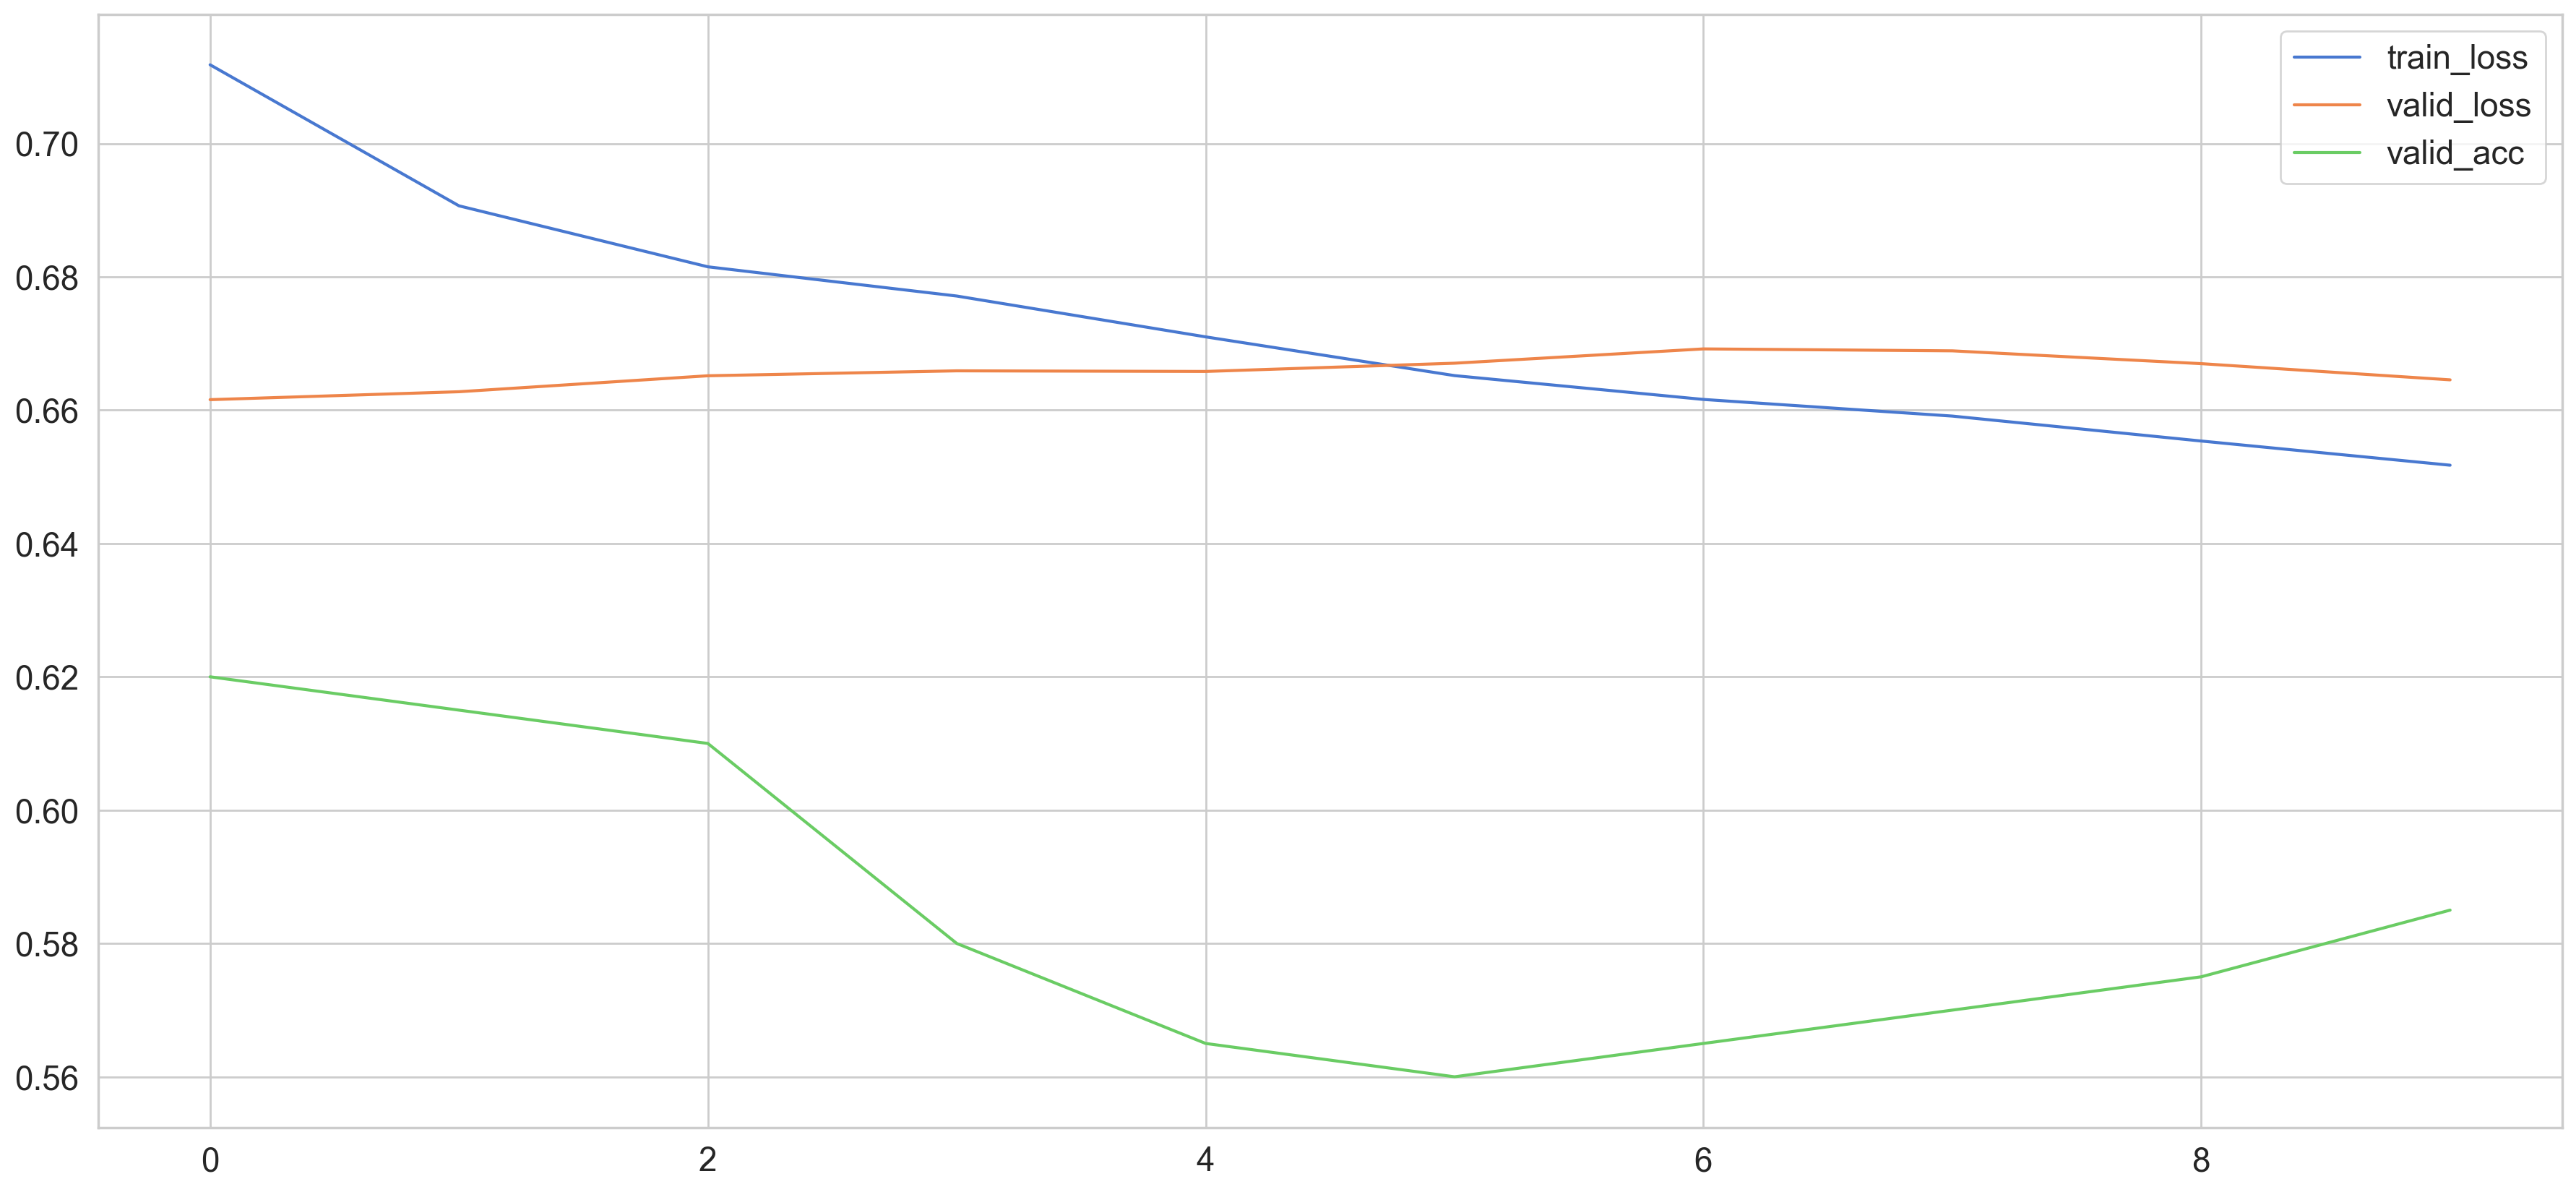

In [114]:
plt.plot(history.history['loss'], label='train_loss')
#plt.plot(history.history['f1_score'], label='train_f1_score')
plt.plot(history.history['val_loss'], label='valid_loss')
plt.plot(history.history['val_acc'], label='valid_acc')
#plt.plot(history.history['val_f1_score'], label='val_f1_score')

plt.legend();

In [85]:
model.evaluate(X_test, y_test)

35/35 [==============================] - 4s 104ms/step - loss: 1.1691 - acc: 0.6941


[1.1691426038742065, 0.6940966248512268]

In [79]:
y_pred = model.predict(X_test)

35/35 [==============================] - 3s 73ms/step


In [80]:
y_pred_bool = y_pred > .5
y_pred_int = np.array([int(item) for item in y_pred_bool], dtype='int8').reshape(-1,1)
print(y_pred_int.shape)
print(type(y_pred_int))
print(y_test.shape)
print(type(y_test))

(1118, 1)
<class 'numpy.ndarray'>
(1118, 1)
<class 'numpy.ndarray'>


In [81]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

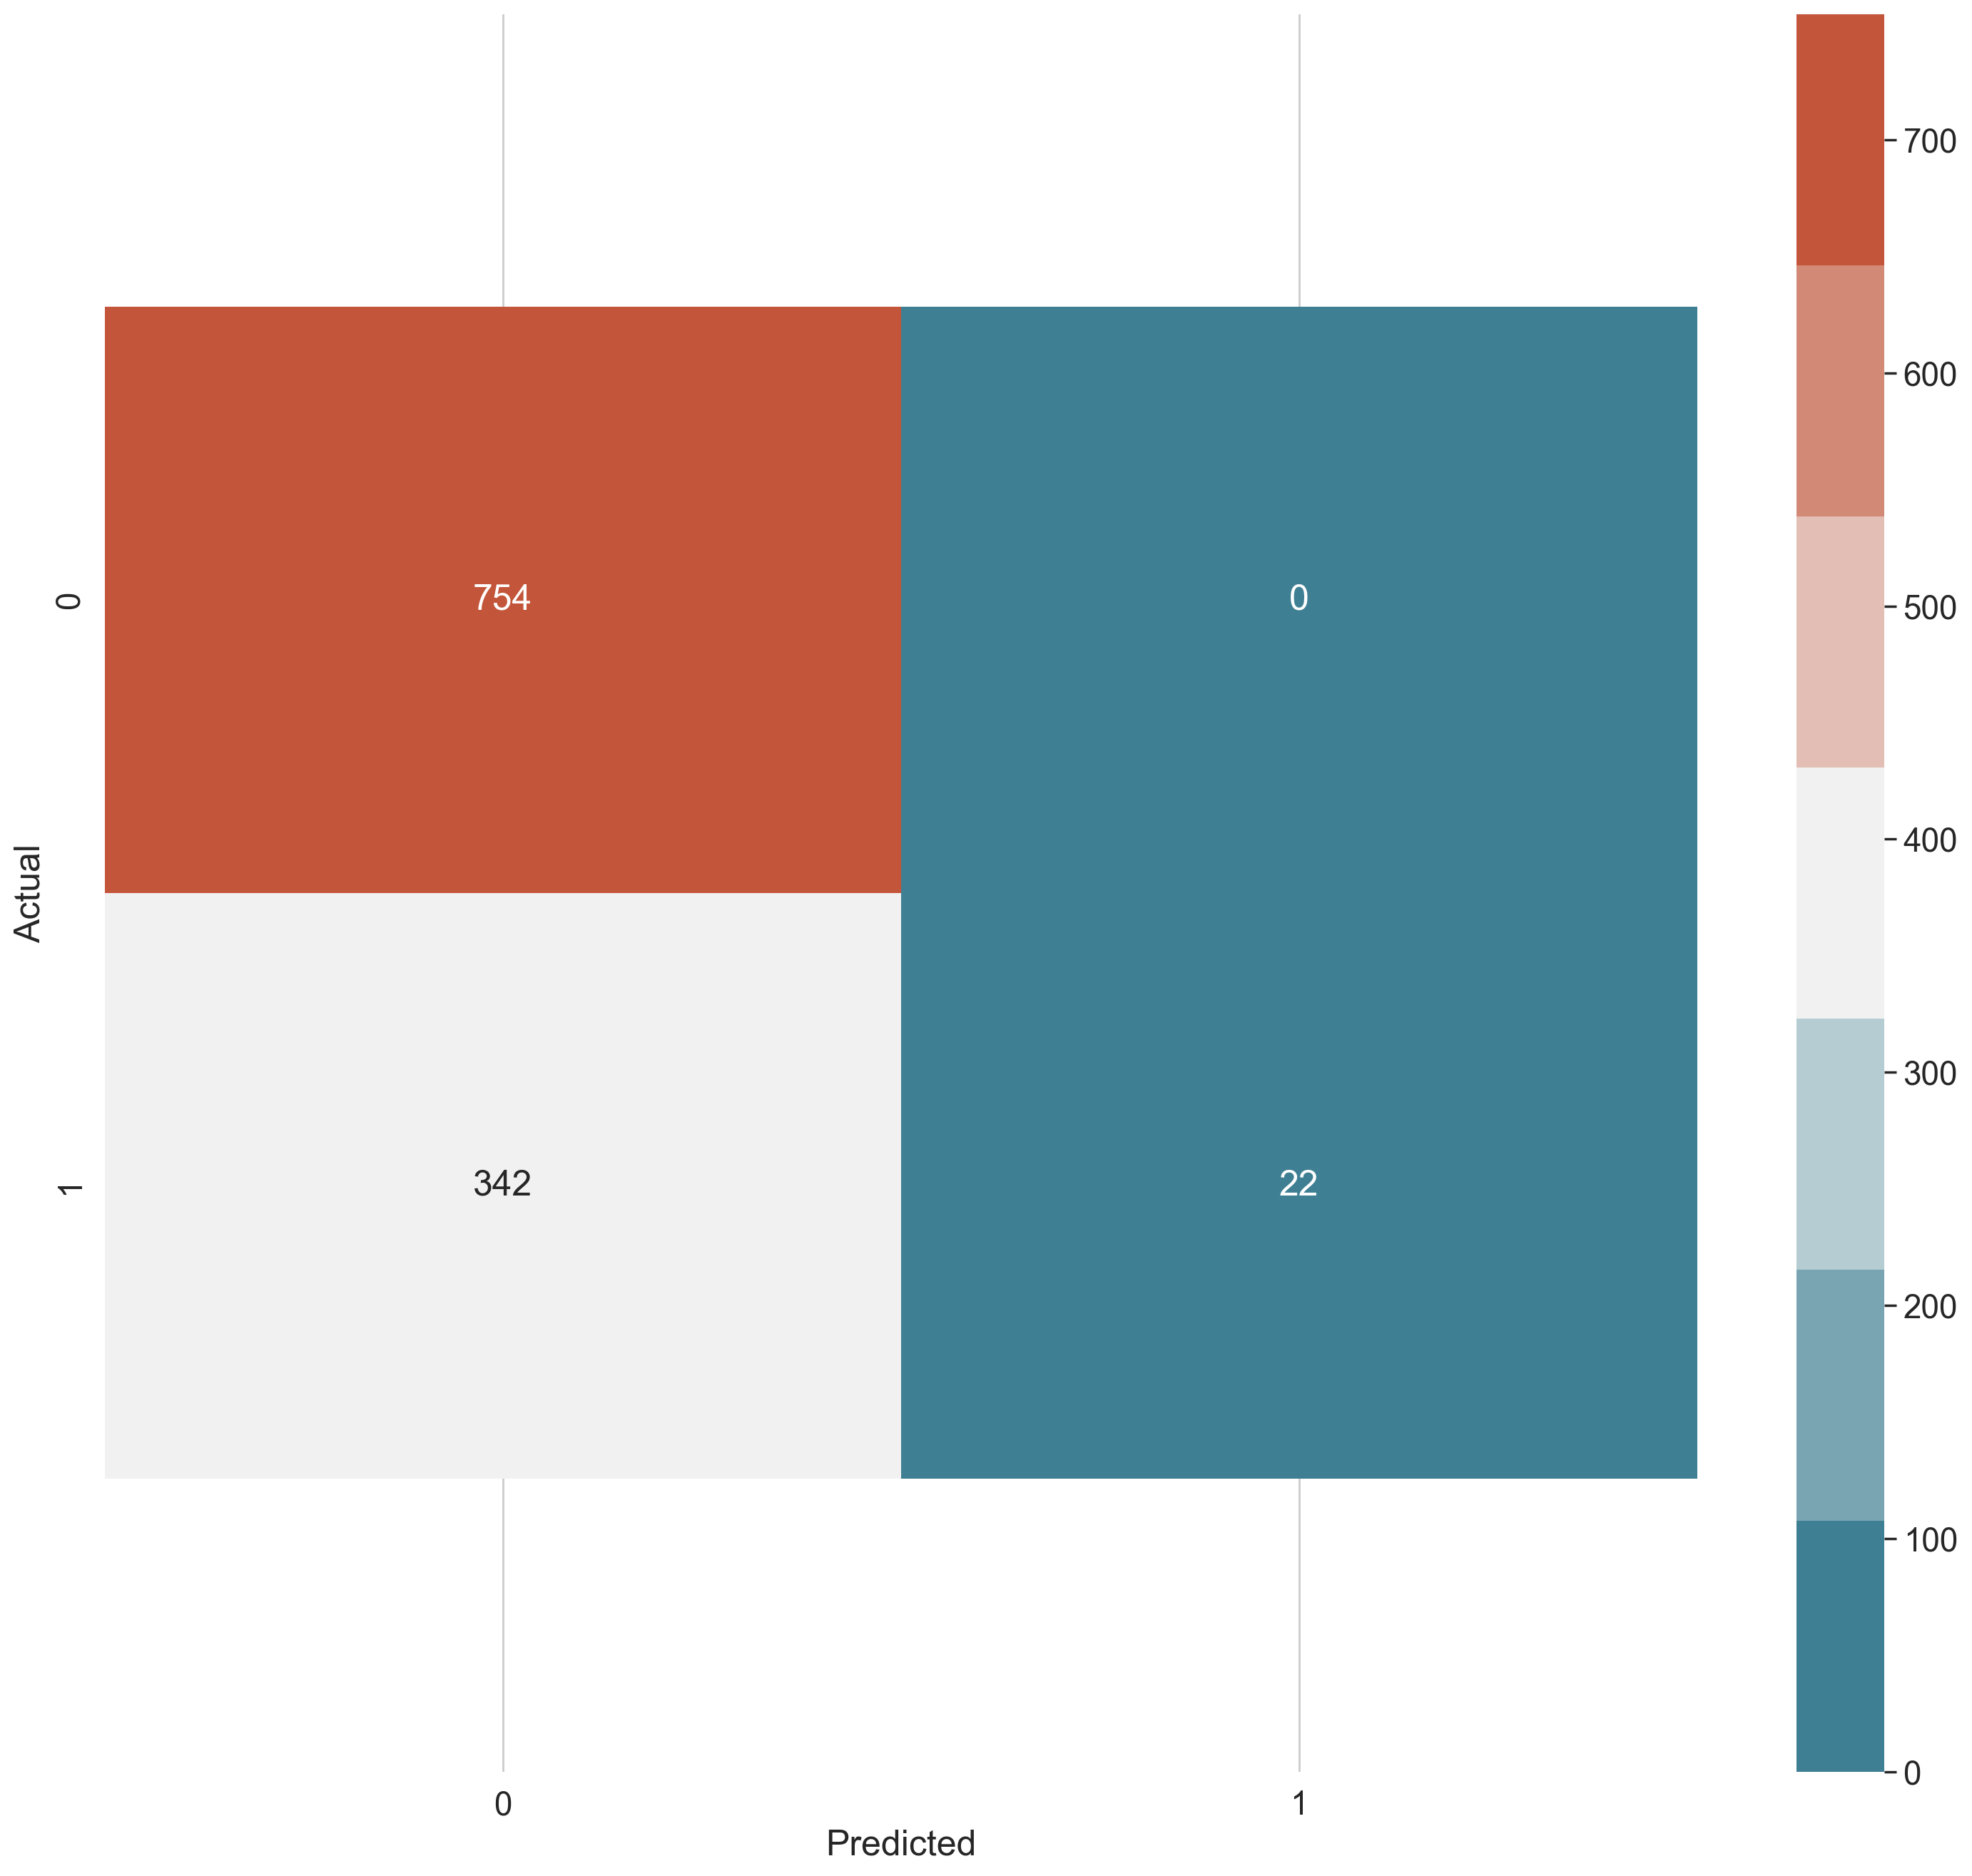

In [82]:
plot_cm(
  y_test,
  y_pred_int,
)

In [35]:
def plot_pred(y_true, y_pred):
  fig, ax = plt.subplots(2)

  ax[0].plot(range(0,len(y_pred)), y_true)
  ax[0].set_title('Truth')
  ax[0].set_ylabel('Class')
  ax[0].set_ylim(0, 1.5) # update the ylim(bottom, top) values

  ax[1].plot(range(0,len(y_pred)), y_pred)
  ax[1].set_title('Predictions')
  ax[1].set_ylabel('Class')
  ax[1].set_xlabel('Time (steps)')
  ax[1].set_ylim(0, 1.5) # update the ylim(bottom, top) values
  plt.show() # ta-da!

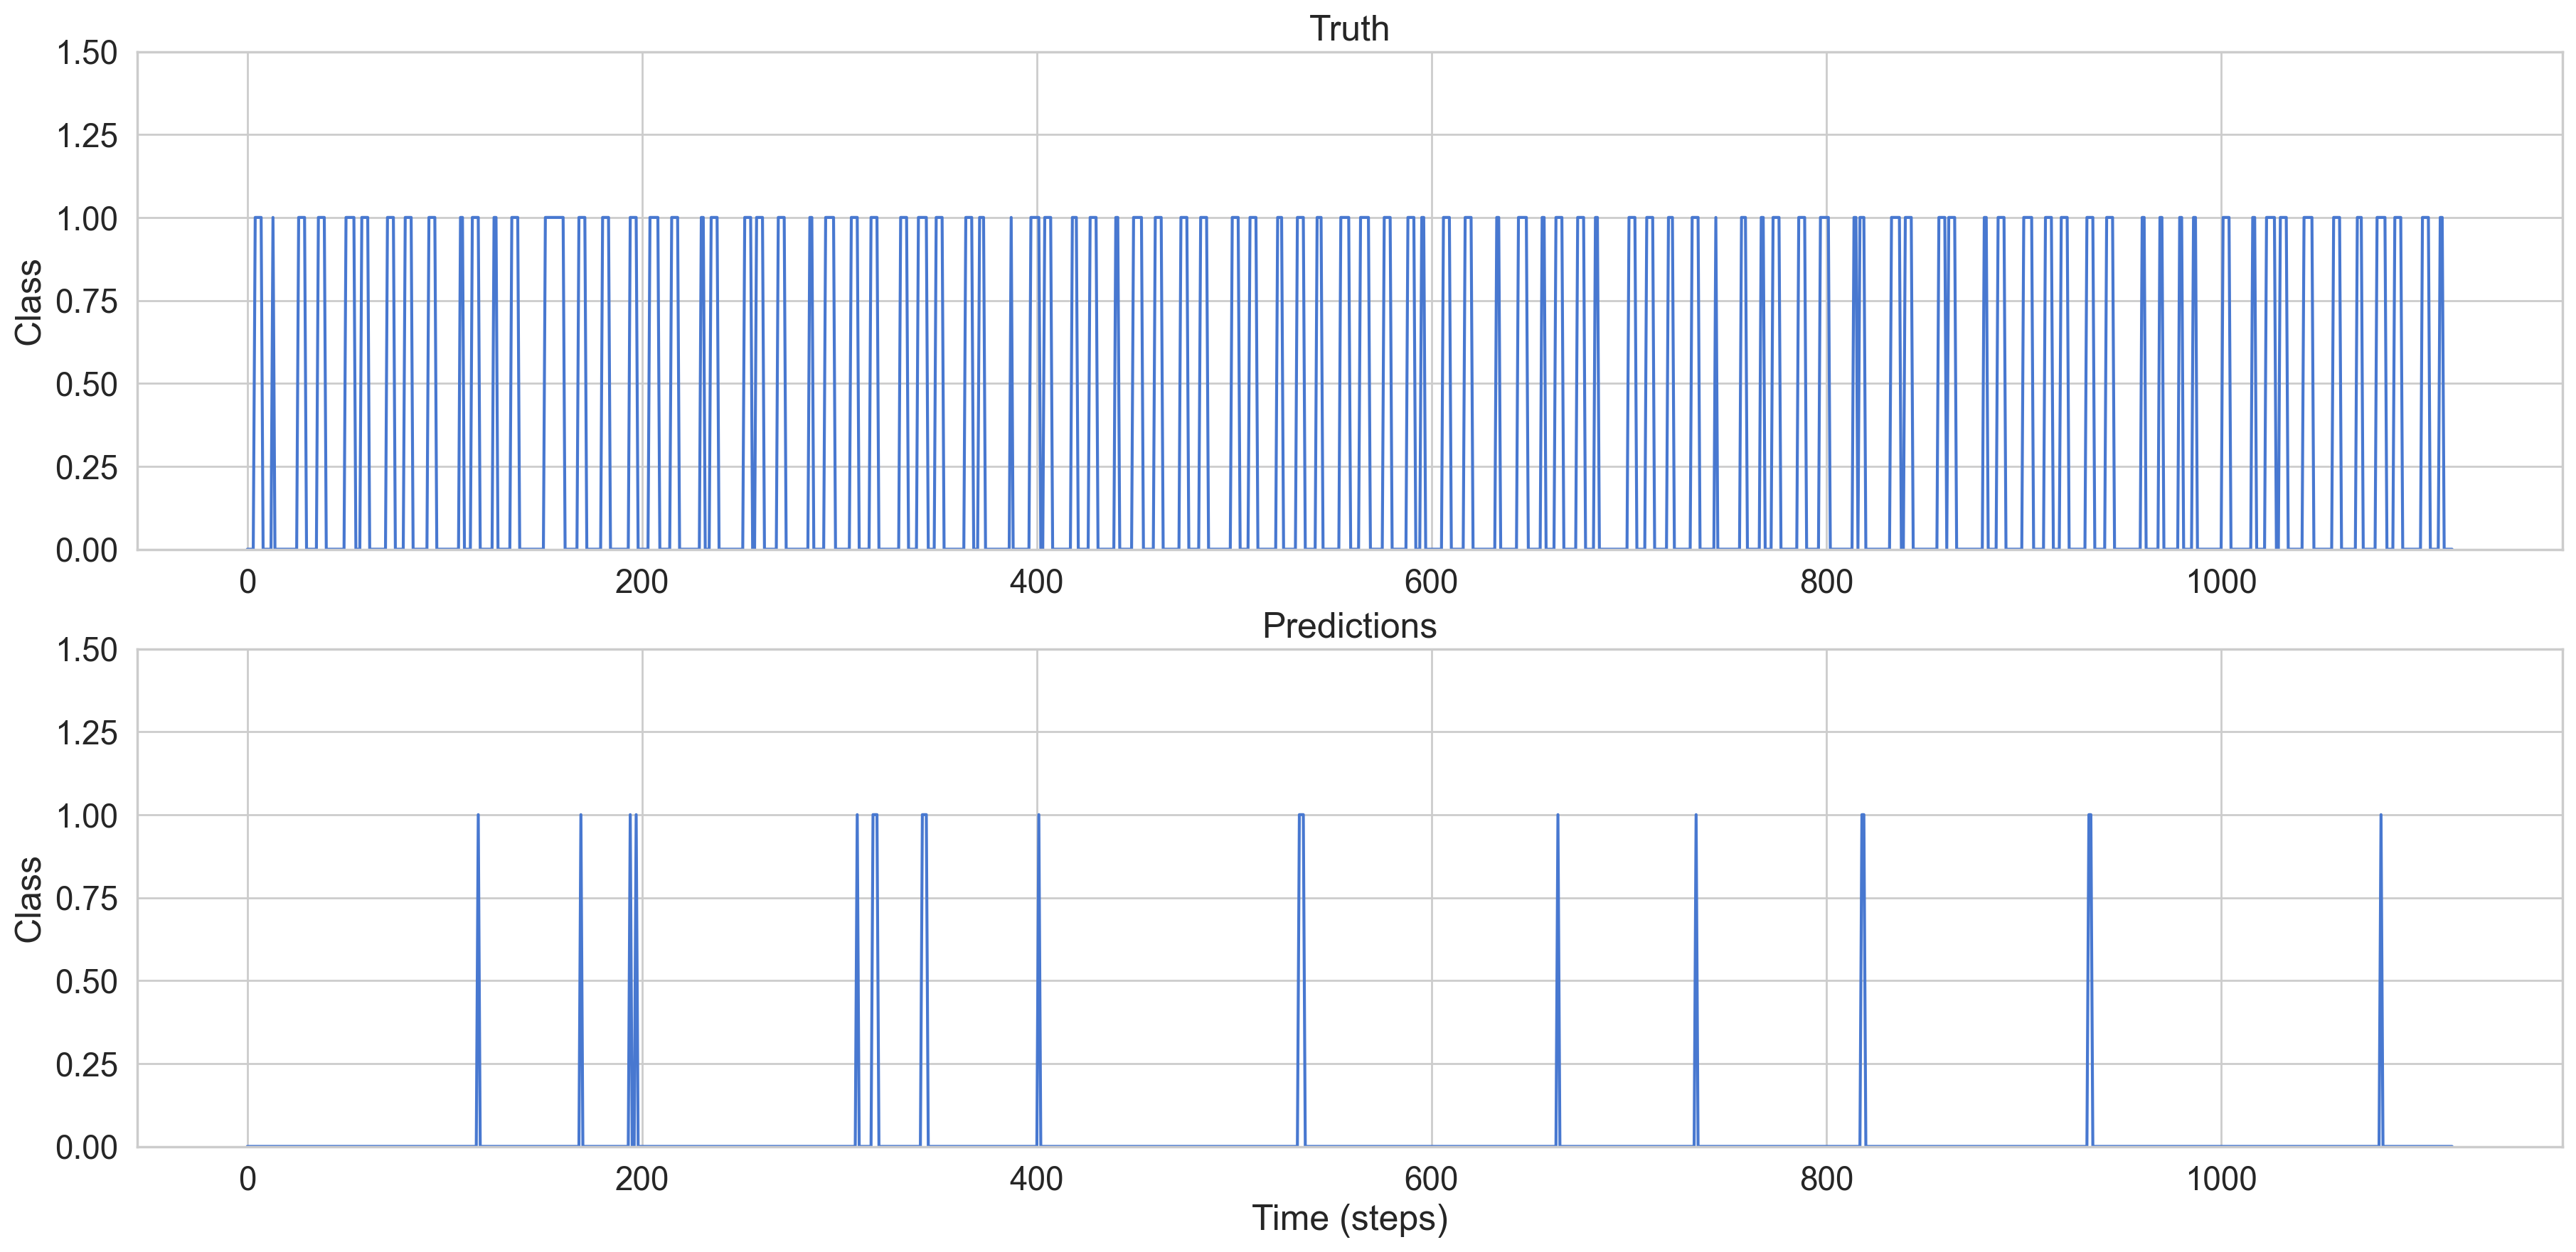

In [83]:
plot_pred(y_test, y_pred_int)

In [489]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred_int,average = 'binary')

0.957004160887656

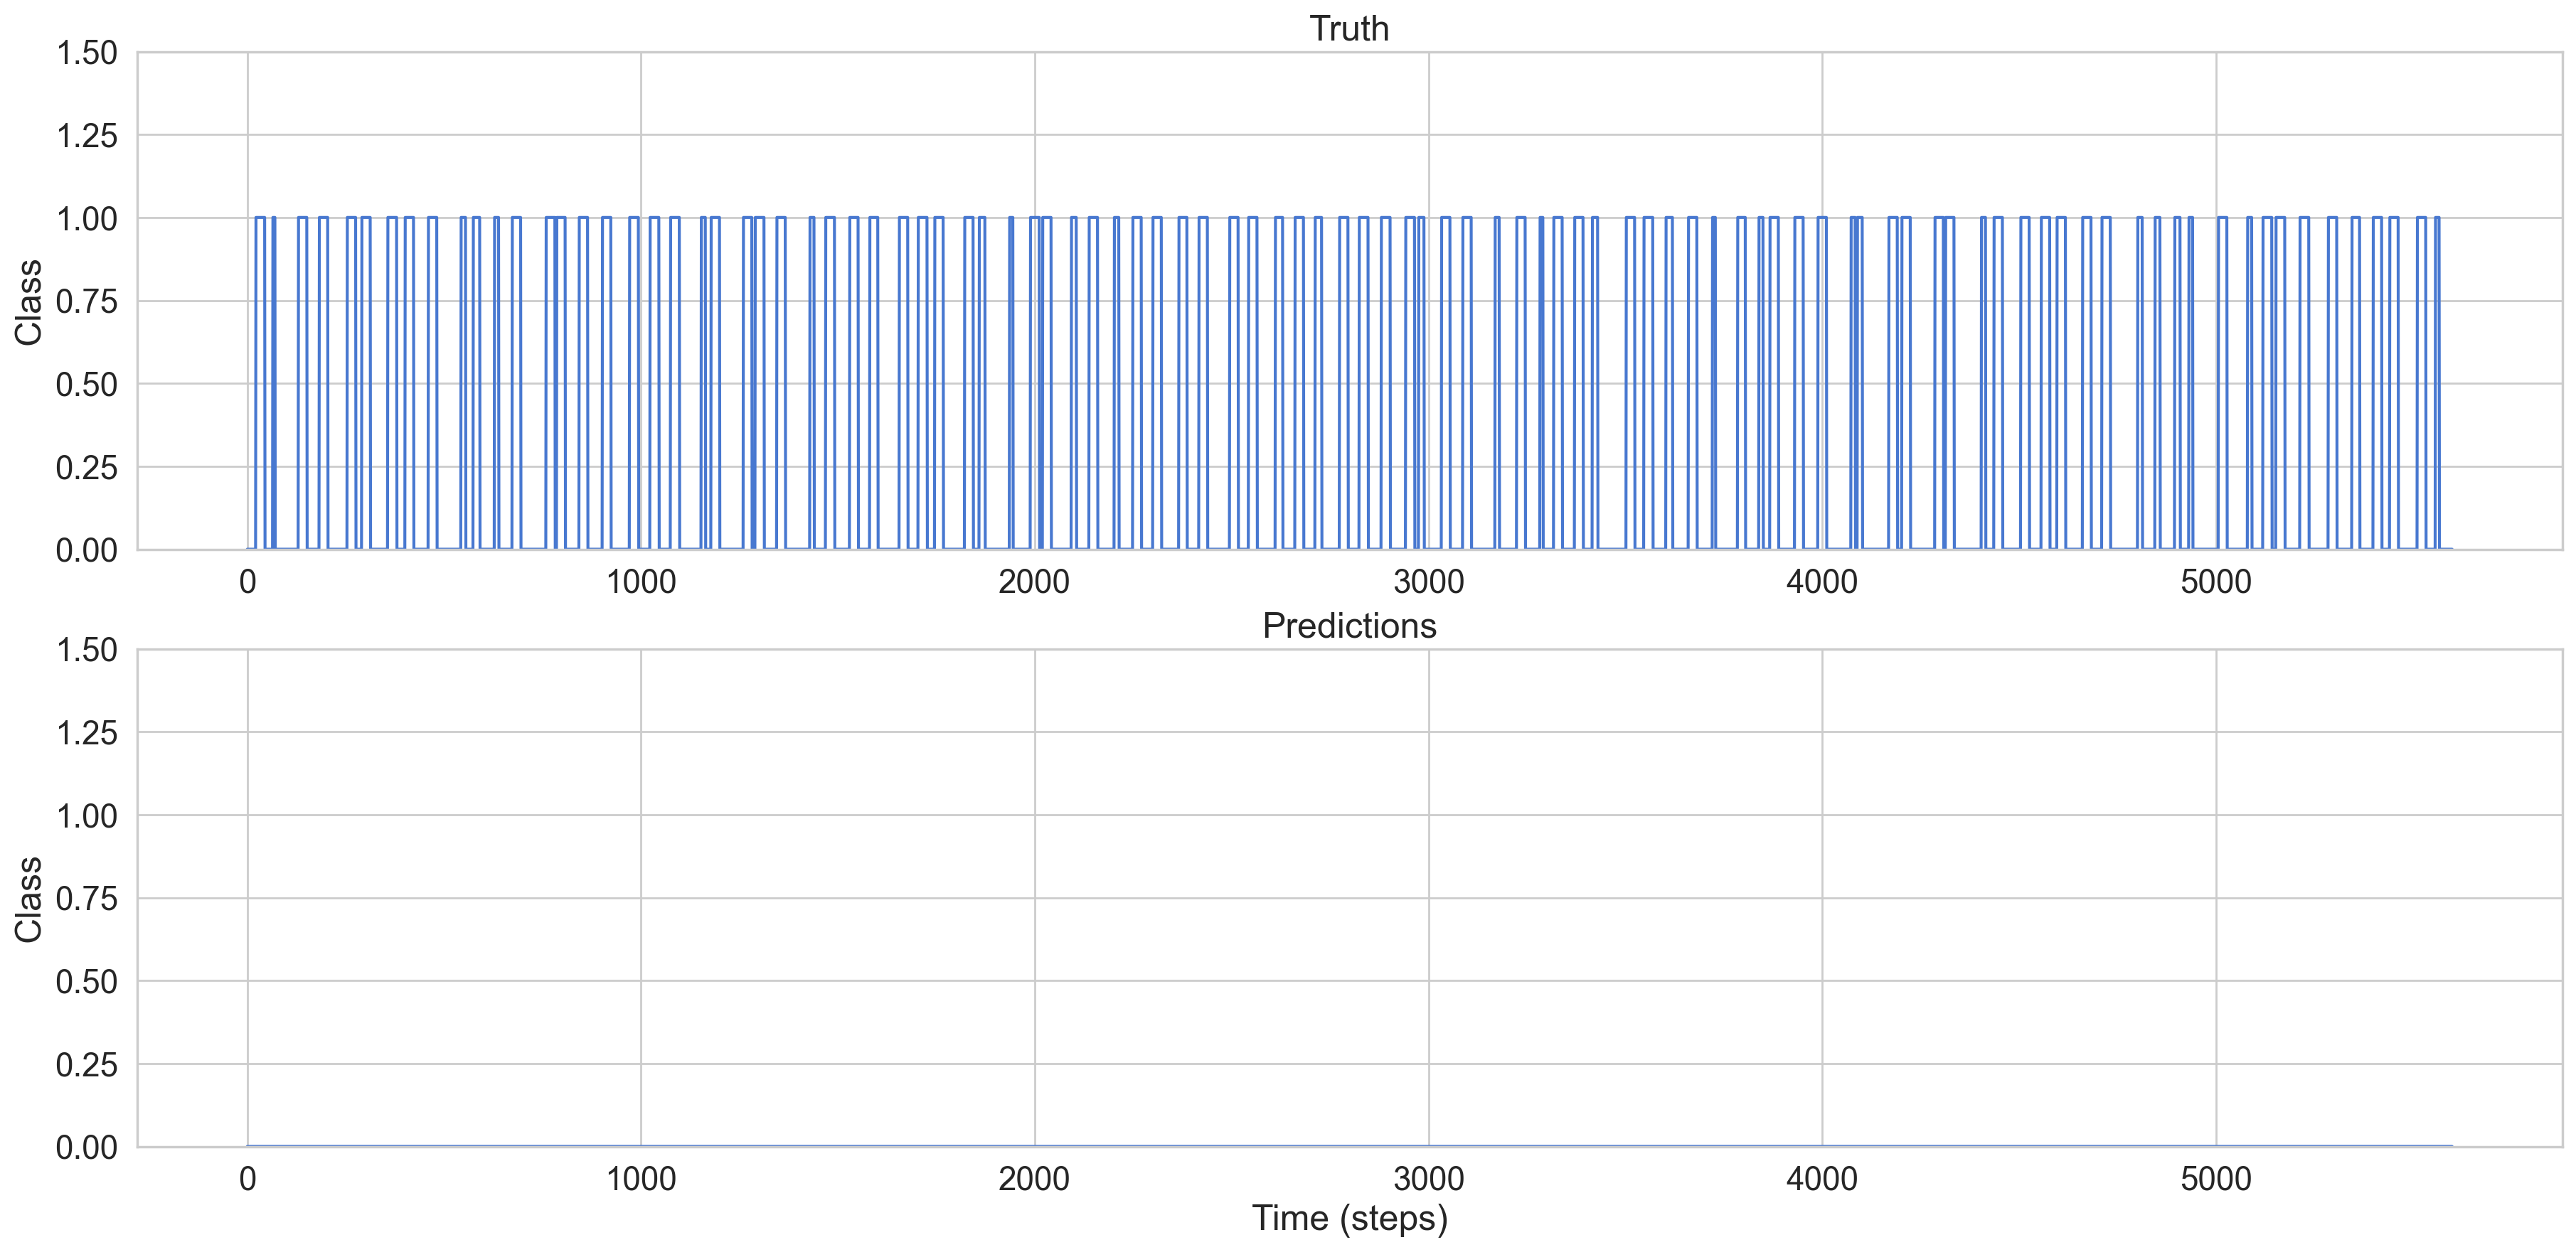

In [66]:
plot_pred(df_test['y'],np.zeros(len(df_test['y'])))

In [685]:
def modeSmoother(data, rolling_window):
    from scipy import stats as st
    smoothed_output = np.zeros([int(rolling_window/2),1],dtype=int)
    k = int(0)
    for i in range(0,len(data)-rolling_window):
        k,dump = st.mode(data[i:i+rolling_window],axis=None)
        smoothed_output = np.append(smoothed_output,k)
    smoothed_output = np.append(smoothed_output,np.zeros([int(rolling_window/2),1],dtype=int))
    return smoothed_output

In [816]:
yout = upSampler(y_pred_test_int, 10)
print(yout.dtype)
l = int(np.round((len(trialFilter(df_test,test_subject,1))%40)/4))
print(l)
yout = np.concatenate((np.zeros([10,1],dtype=int),yout,np.zeros([l,1],dtype=int)),axis = None)
print(yout.shape)

int64
8
(9498,)


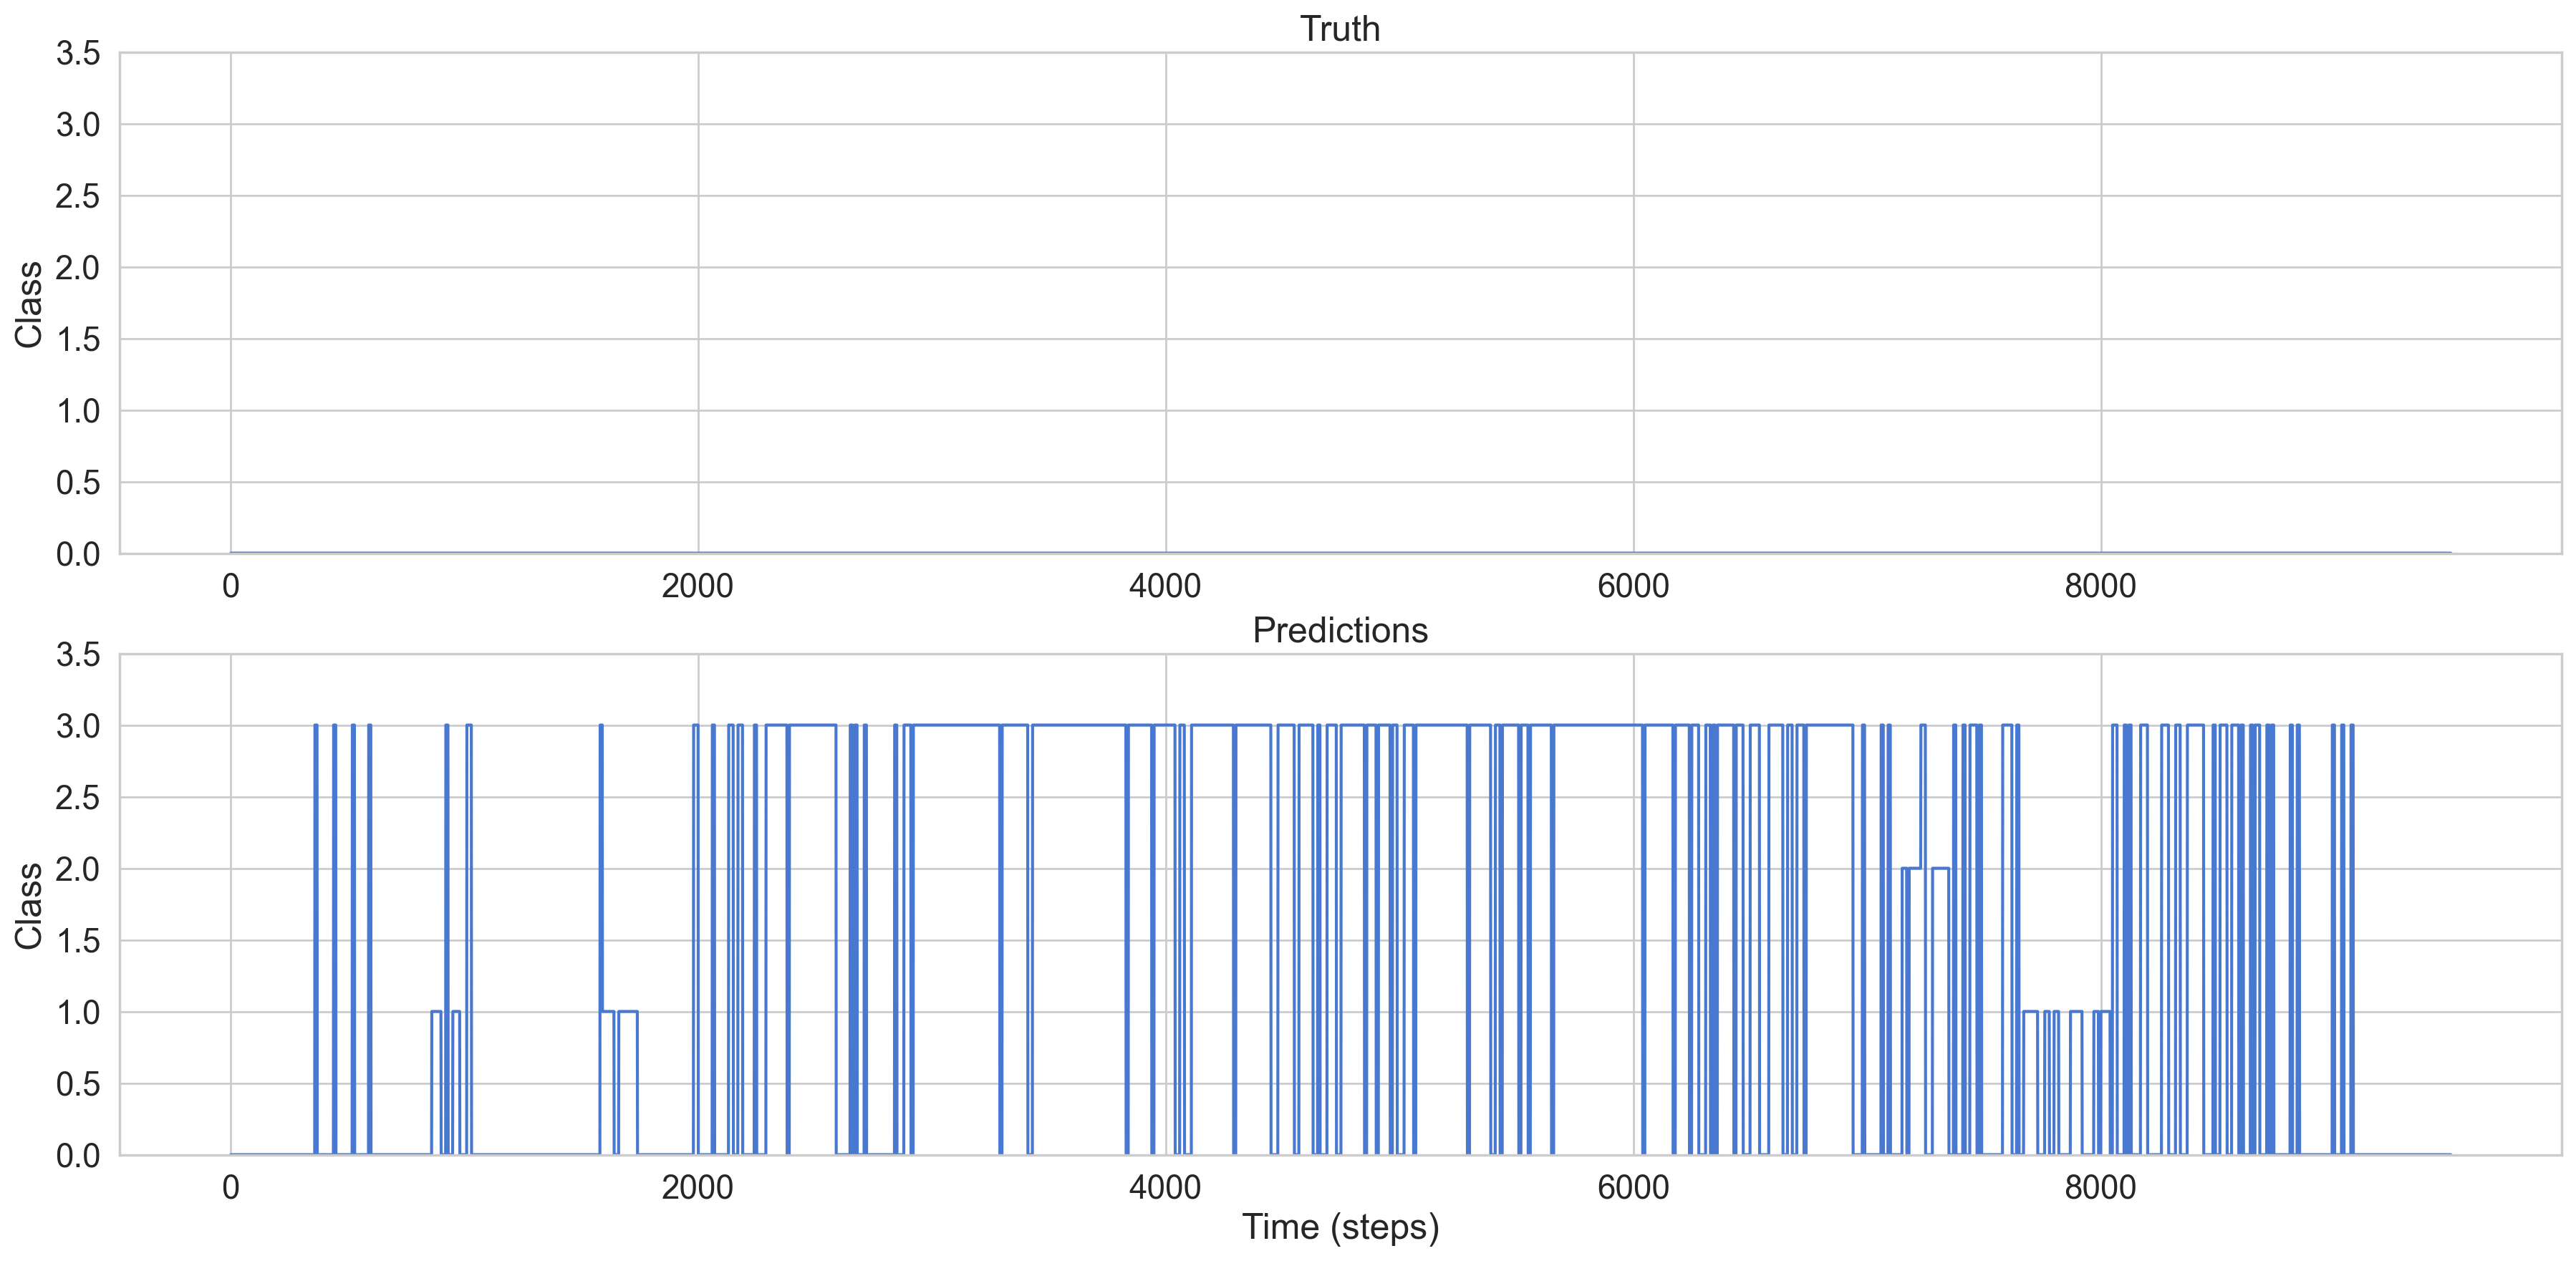

9498


In [817]:
plot_pred(np.zeros([len(yout)]), yout)
print(len(yout))
#print(46038)


In [803]:
testDir = 'TestPredictions'
!mkdir -p TestPredictions
fileName = [
'subject_009_01__y.csv',
'subject_010_01__y.csv',
'subject_011_01__y.csv',
'subject_012_01__y.csv']
np.savetxt(f'{testDir}/{fileName[test_subject-9]}', smoothed_output, fmt='%i',delimiter=",")

In [382]:
testDir = 'TestPredictions'
os.mkdir(testDir)
#print(f'{testDir}')
fileName = [
'subject_009_01__y.csv',
'subject_010_01__y.csv',
'subject_011_01__y.csv',
'subject_012_01__y.csv']
fileSize = [ 9498, 12270, 12940, 11330]
fileIndex = np.array([],dtype = int)
for i in range(0,len(fileSize)+1):
    if i == 0:
        fileIndex = np.append(fileIndex,int(0))
    else:
        fileIndex = np.append(fileIndex, fileSize[i-1]+fileIndex[i-1])
print(fileIndex)
print(y_pred_test_10.dtype)
for i in range(0,len(fileName)):
    np.savetxt(f'{testDir}/{fileName[i]}', y_pred_test_10[fileIndex[i]:fileIndex[i+1]], fmt='%i',delimiter=",")



TestPredictions
[    0  9498 21768 34708 46038]
int64
